In [1]:
import codigo
from codigo import utils
from codigo import model_LSTM
from codigo import model_utils
from cg_ega.cg_ega import CG_EGA

In [2]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
modeloBasePath='modelos/modeloGeneral/vanilla_dropout.h5'
modeloSave='/transfer_vanilla_dropout.h5'

In [5]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

# Paciente Q1

In [6]:
paciente='paciente1'

In [7]:
with open('dataset/generado/'+paciente+'/array_Xtrain.npy', 'rb') as f:
    array_Xtrain = np.load(f)

In [8]:
len(array_Xtrain)

1523

In [9]:
with open('dataset/generado/'+paciente+'/array_Ytrain.npy', 'rb') as f:
    array_Ytrain = np.load(f)

In [10]:
len(array_Ytrain)

1523

In [11]:
with open('dataset/generado/'+paciente+'/array_Xval.npy', 'rb') as f:
    array_Xval = np.load(f)

In [12]:
len(array_Xval)

190

In [13]:
with open('dataset/generado/'+paciente+'/array_Yval.npy', 'rb') as f:
    array_Yval = np.load(f)

In [14]:
len(array_Yval)

190

In [15]:
with open('dataset/generado/'+paciente+'/array_Xtest.npy', 'rb') as f:
    array_Xtest = np.load(f)

In [16]:
len(array_Xtest)

191

In [17]:
with open('dataset/generado/'+paciente+'/array_Ytest.npy', 'rb') as f:
    array_Ytest = np.load(f)

In [18]:
len(array_Ytest)

191

In [19]:
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=3, min_delta=0.001)

# Rendimiento del Modelo base

In [20]:
base_model = keras.models.load_model(modeloBasePath)

6/6 [==============================] - 0s 6ms/step


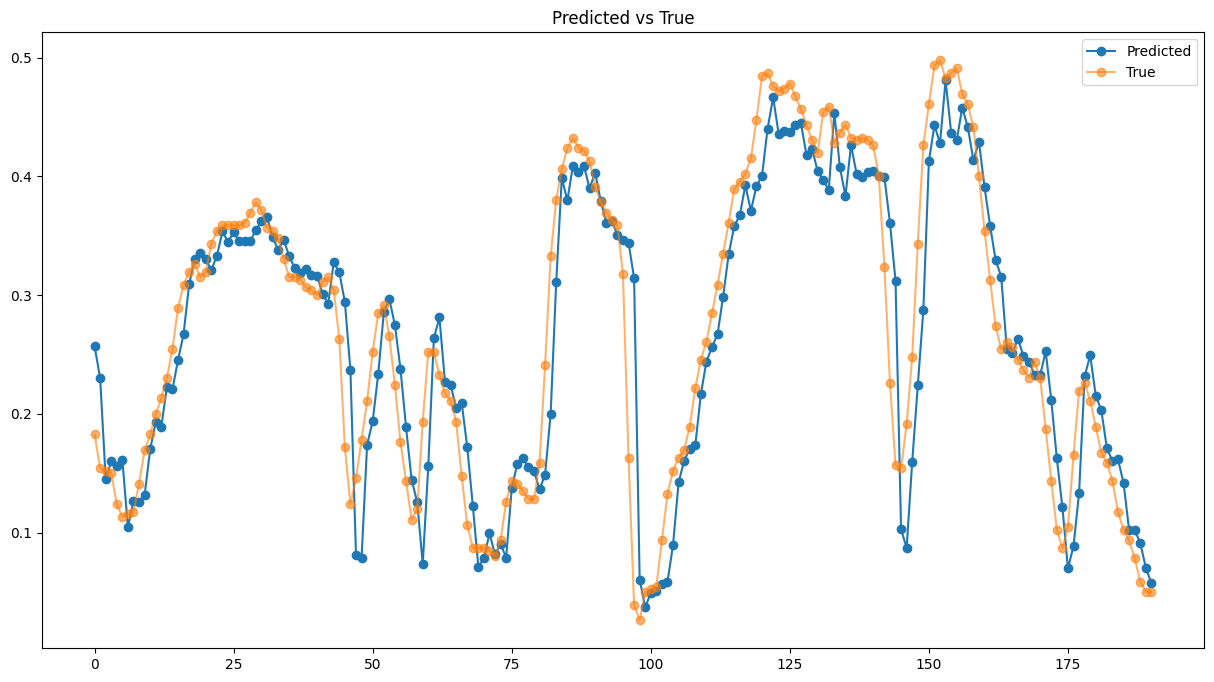

In [21]:
yhat = base_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [22]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.03631403151294948,
 'mse': 0.05150329549445391,
 'rmse': 0.0026525894467890367}

# Iniciamos transfer learning

In [23]:
# Freeze the base_model
base_model.trainable = False

In [24]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [25]:
x = base_model.layers[-3].output 

x = tf.keras.layers.Dense(32, activation='relu',name='newLayer')(x) 
predictions = tf.keras.layers.Dense(1,name='output')(x) 
    
finetune_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [26]:
base_model.layers[-3].output

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_1')>

In [27]:
finetune_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 5)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 newLayer (Dense)            (None, 32)                1056  

In [28]:
finetune_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae','mse'])

history =finetune_model.fit(array_Xtrain, array_Ytrain,epochs=epochs, validation_data=(array_Xval, array_Yval), shuffle=False, callbacks=[early_stopping])
finetune_model.save('modelos/'+paciente+modeloSave)

Epoch 1/100
48/48 [==============================] - 2s 16ms/step - loss: 0.1430 - mae: 0.2991 - mse: 0.1430 - val_loss: 0.0683 - val_mae: 0.2044 - val_mse: 0.0683
Epoch 2/100
48/48 [==============================] - 0s 9ms/step - loss: 0.1143 - mae: 0.2649 - mse: 0.1143 - val_loss: 0.0543 - val_mae: 0.1817 - val_mse: 0.0543
Epoch 3/100
48/48 [==============================] - 0s 9ms/step - loss: 0.0891 - mae: 0.2338 - mse: 0.0891 - val_loss: 0.0422 - val_mae: 0.1614 - val_mse: 0.0422
Epoch 4/100
48/48 [==============================] - 0s 10ms/step - loss: 0.0674 - mae: 0.2037 - mse: 0.0674 - val_loss: 0.0320 - val_mae: 0.1424 - val_mse: 0.0320
Epoch 5/100
48/48 [==============================] - 0s 10ms/step - loss: 0.0490 - mae: 0.1750 - mse: 0.0490 - val_loss: 0.0239 - val_mae: 0.1246 - val_mse: 0.0239
Epoch 6/100
48/48 [==============================] - 0s 10ms/step - loss: 0.0355 - mae: 0.1503 - mse: 0.0355 - val_loss: 0.0179 - val_mae: 0.1093 - val_mse: 0.0179
Epoch 7/100
48/48 

6/6 [==============================] - 0s 5ms/step - loss: 0.0038 - mae: 0.0481 - mse: 0.0038
test loss, test acc: [0.003822365775704384, 0.04806908592581749, 0.003822365775704384]


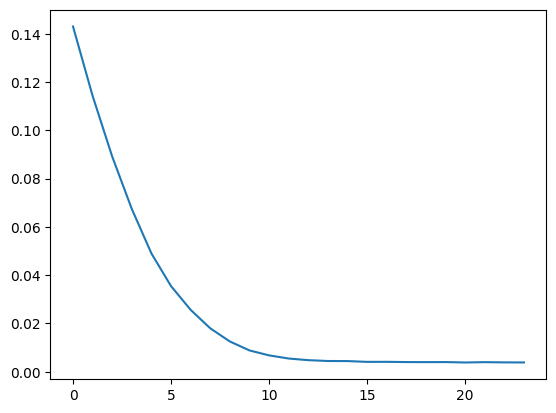

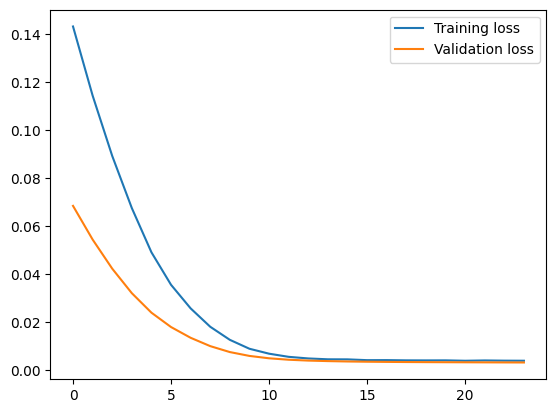

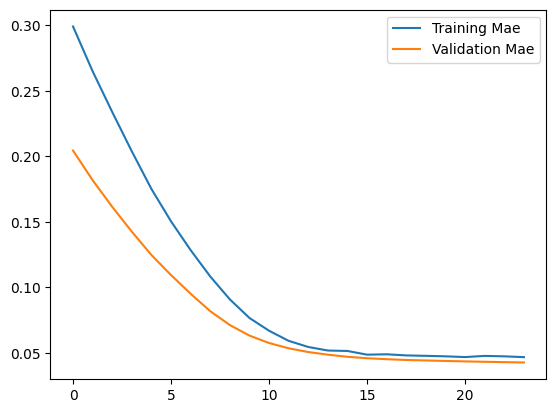

In [29]:
model_utils.modelEvaluateTraining(finetune_model,history,array_Xtest, array_Ytest)

6/6 [==============================] - 0s 4ms/step


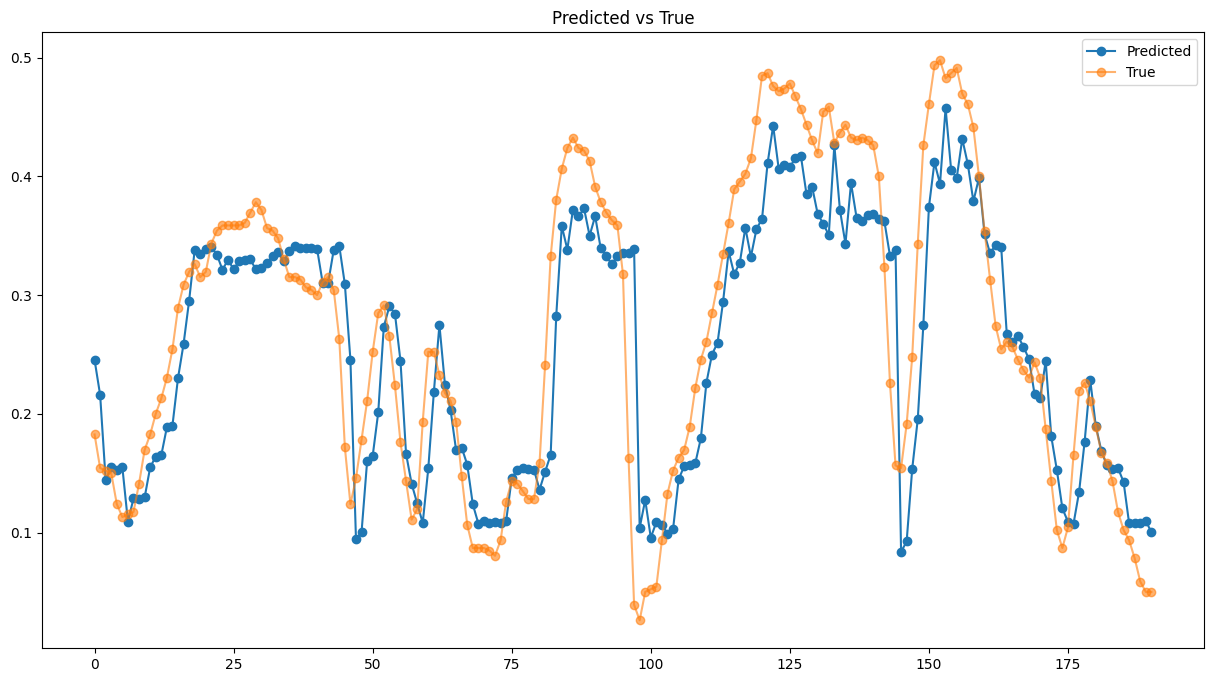

In [30]:
yhat = finetune_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [31]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.048069084775412566,
 'mse': 0.06182528359451439,
 'rmse': 0.0038223656915421303}

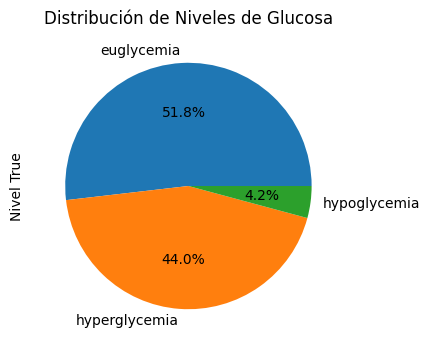

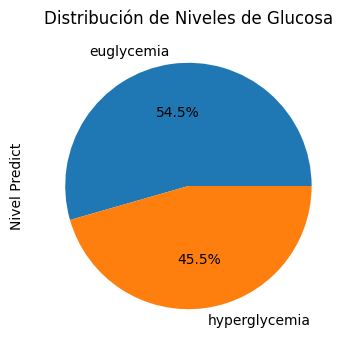

Glucose level True  Nivel True  Glucose level Predict Nivel Predict
0               124.0  euglycemia             152.891495    euglycemia
1               111.0  euglycemia             139.369659    euglycemia
2               110.0  euglycemia             106.228348    euglycemia
3               109.0  euglycemia             111.228172    euglycemia
4                97.0  euglycemia             110.291496    euglycemia

In [32]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


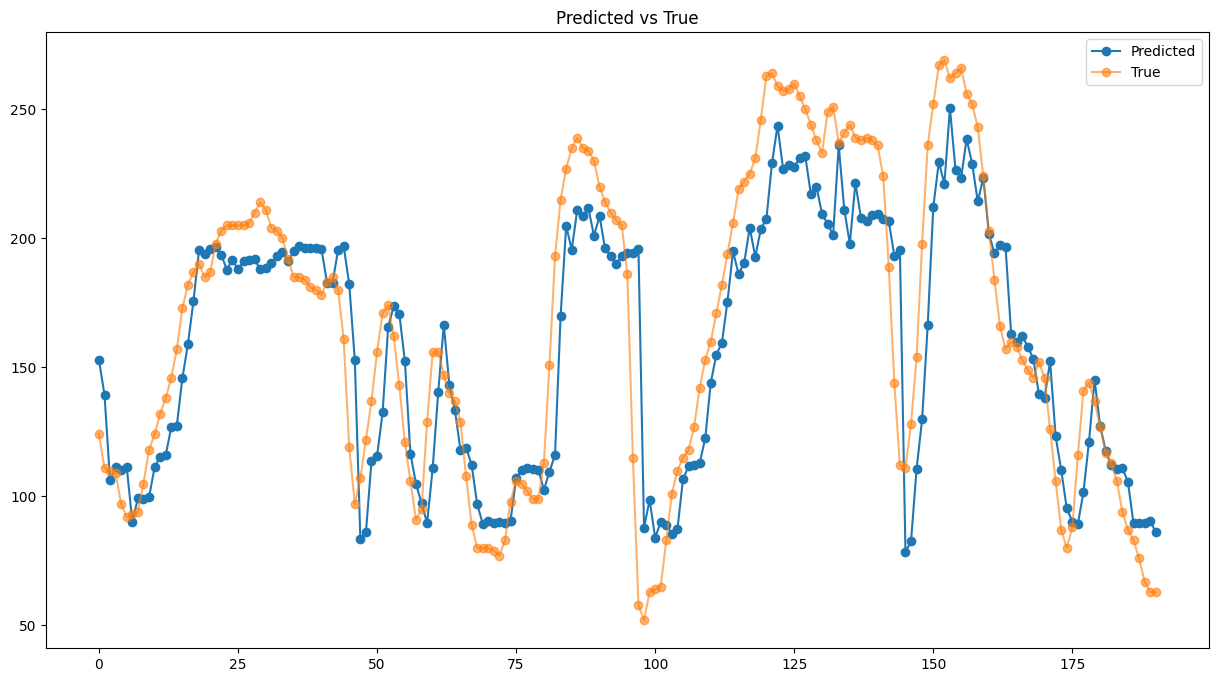

{'mae': 22.111778099499446,
 'mse': 28.439629587732302,
 'rmse': 808.8125310874186}

In [33]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [34]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=df_glucose['Glucose level True']
dfPlot['y_pred']=df_glucose['Glucose level Predict']
dfPlot.index=pd.date_range("2023-01-01", periods=len(df_glucose['Glucose level True']), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   124.0  152.891495
2023-01-01 00:15:00   111.0  139.369659
2023-01-01 00:30:00   110.0  106.228348
2023-01-01 00:45:00   109.0  111.228172
2023-01-01 01:00:00    97.0  110.291496
...                     ...         ...
2023-01-02 22:30:00    83.0   89.564514
2023-01-02 22:45:00    76.0   89.609810
2023-01-02 23:00:00    67.0   89.679375
2023-01-02 23:15:00    63.0   90.552773
2023-01-02 23:30:00    63.0   86.078415

[191 rows x 2 columns]

AP, BE, EP: (0.868421052631579, 0.08947368421052632, 0.042105263157894736)


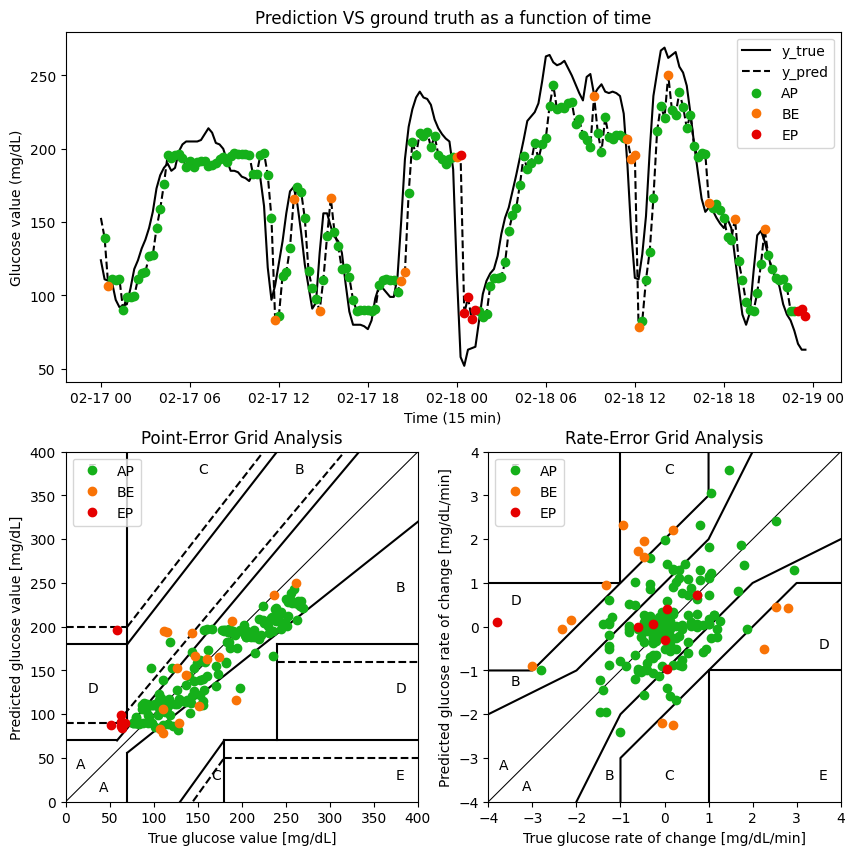

In [35]:
freq = 15
cg_ega = CG_EGA(dfPlot, freq)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

# Paciente Q2

In [36]:
paciente='paciente2'

In [37]:
with open('dataset/generado/'+paciente+'/array_Xtrain.npy', 'rb') as f:
    array_Xtrain = np.load(f)

In [38]:
len(array_Xtrain)

13931

In [39]:
with open('dataset/generado/'+paciente+'/array_Ytrain.npy', 'rb') as f:
    array_Ytrain = np.load(f)

In [40]:
len(array_Ytrain)

13931

In [41]:
with open('dataset/generado/'+paciente+'/array_Xval.npy', 'rb') as f:
    array_Xval = np.load(f)

In [42]:
len(array_Xval)

1741

In [43]:
with open('dataset/generado/'+paciente+'/array_Yval.npy', 'rb') as f:
    array_Yval = np.load(f)

In [44]:
len(array_Yval)

1741

In [45]:
with open('dataset/generado/'+paciente+'/array_Xtest.npy', 'rb') as f:
    array_Xtest = np.load(f)

In [46]:
len(array_Xtest)

1742

In [47]:
with open('dataset/generado/'+paciente+'/array_Ytest.npy', 'rb') as f:
    array_Ytest = np.load(f)

In [48]:
len(array_Ytest)

1742

In [49]:
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=3, min_delta=0.001)

# Rendimiento del Modelo base

In [50]:
base_model = keras.models.load_model(modeloBasePath)

55/55 [==============================] - 0s 4ms/step


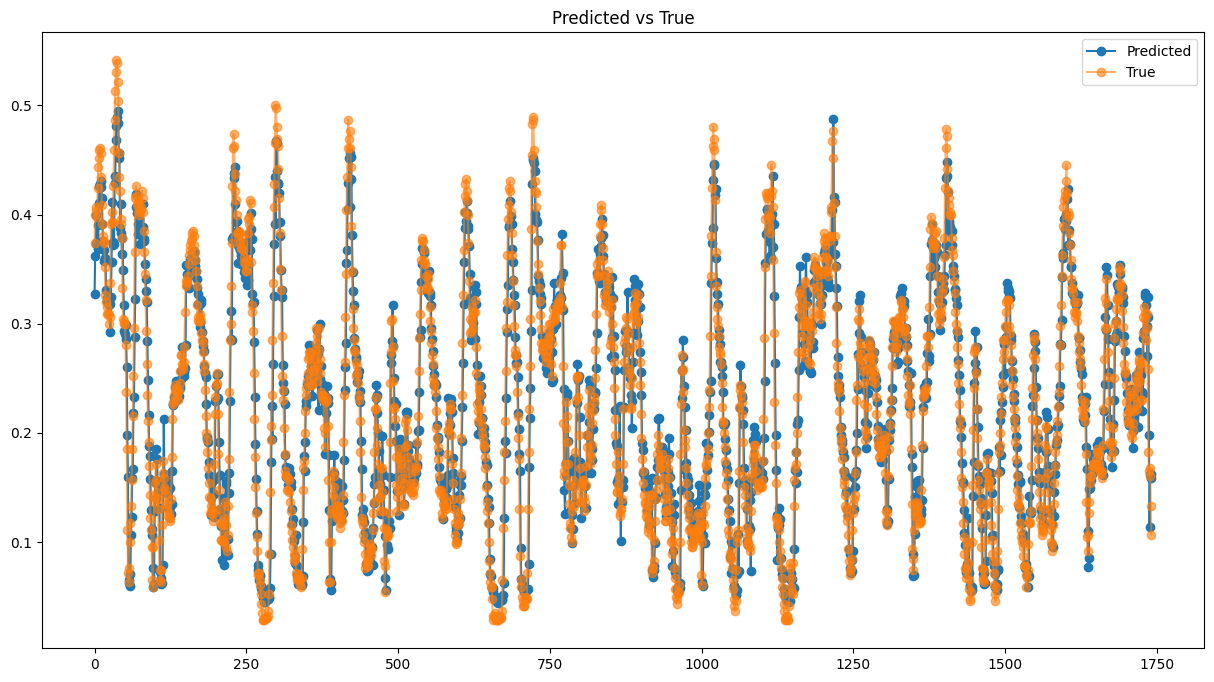

In [51]:
yhat = base_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [52]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.022967179749626455,
 'mse': 0.02998608648691033,
 'rmse': 0.0008991653828004663}

# Iniciamos transfer learning

In [53]:
# Freeze the base_model
base_model.trainable = False

In [54]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [55]:
x = base_model.layers[-2].output 

x = tf.keras.layers.Dense(16, activation='relu',name='newLayer')(x) 
predictions = tf.keras.layers.Dense(1,name='output')(x) 
    
finetune_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [56]:
base_model.layers[-2].output

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dropout_2')>

In [57]:
finetune_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 5)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0   

In [58]:
finetune_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae','mse'])

history =finetune_model.fit(array_Xtrain, array_Ytrain,epochs=epochs, validation_data=(array_Xval, array_Yval), shuffle=False, callbacks=[early_stopping])
finetune_model.save('modelos/'+paciente+modeloSave)

Epoch 1/100
436/436 [==============================] - 5s 9ms/step - loss: 0.0032 - mae: 0.0374 - mse: 0.0032 - val_loss: 0.0024 - val_mae: 0.0370 - val_mse: 0.0024
Epoch 2/100
436/436 [==============================] - 3s 8ms/step - loss: 0.0010 - mae: 0.0228 - mse: 0.0010 - val_loss: 0.0011 - val_mae: 0.0253 - val_mse: 0.0011
Epoch 3/100
436/436 [==============================] - 3s 8ms/step - loss: 8.1827e-04 - mae: 0.0204 - mse: 8.1827e-04 - val_loss: 0.0012 - val_mae: 0.0263 - val_mse: 0.0012
Epoch 4/100
436/436 [==============================] - 3s 8ms/step - loss: 7.5193e-04 - mae: 0.0193 - mse: 7.5193e-04 - val_loss: 0.0012 - val_mae: 0.0271 - val_mse: 0.0012
Epoch 5/100
436/436 [==============================] - 4s 8ms/step - loss: 7.4783e-04 - mae: 0.0191 - mse: 7.4783e-04 - val_loss: 0.0011 - val_mae: 0.0265 - val_mse: 0.0011


55/55 [==============================] - 0s 7ms/step - loss: 0.0011 - mae: 0.0264 - mse: 0.0011
test loss, test acc: [0.0011416616616770625, 0.026373354718089104, 0.0011416616616770625]


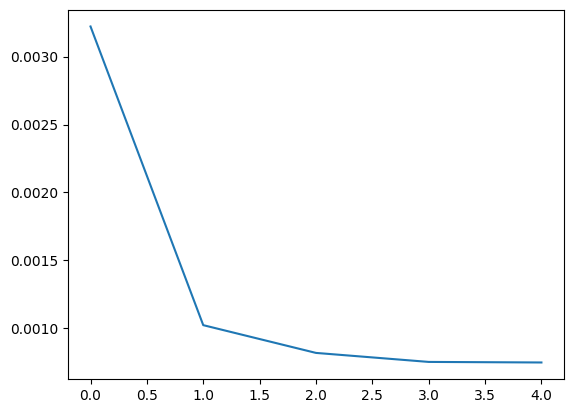

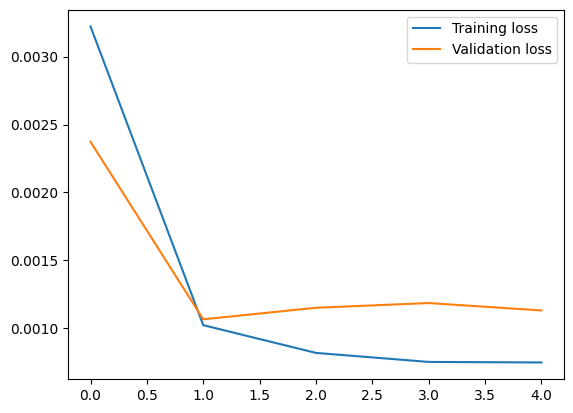

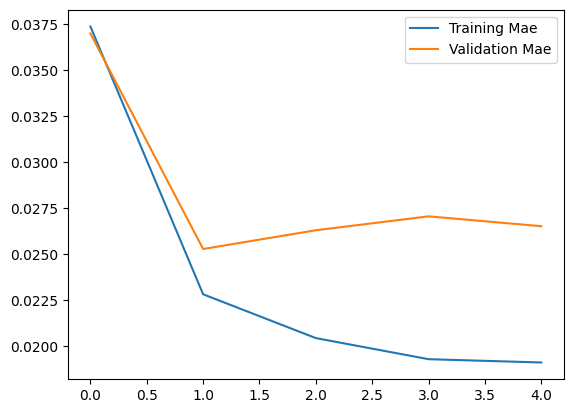

In [59]:
model_utils.modelEvaluateTraining(finetune_model,history,array_Xtest, array_Ytest)

55/55 [==============================] - 1s 5ms/step


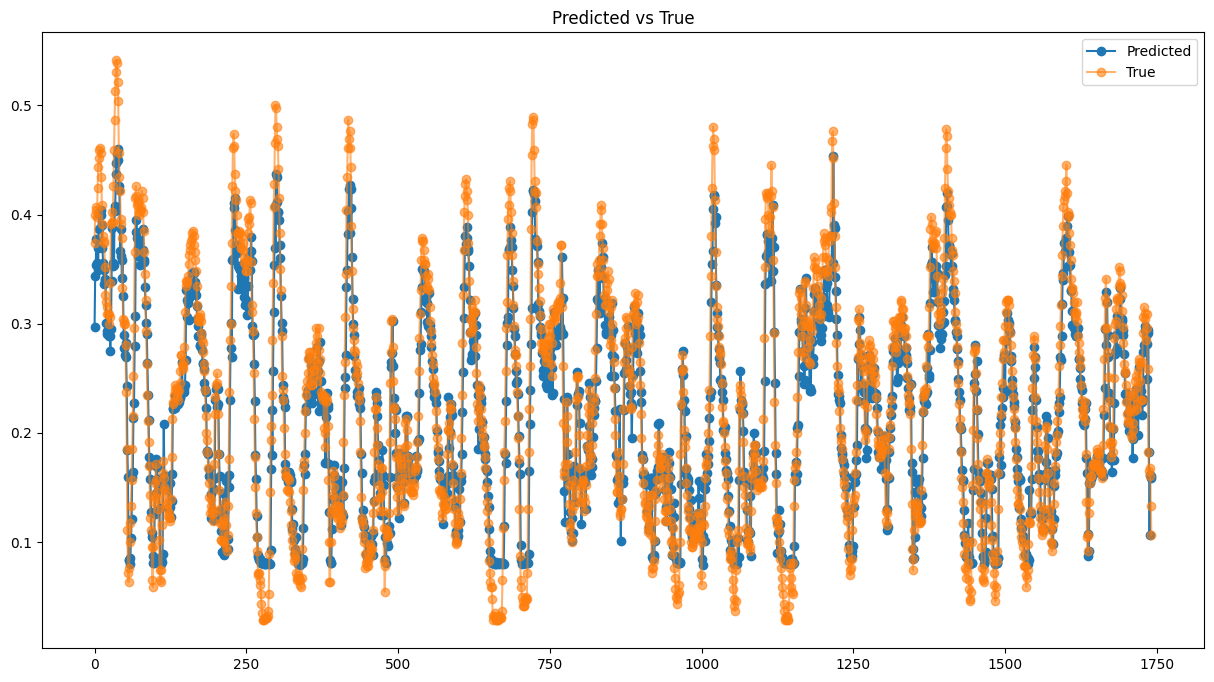

In [60]:
yhat = finetune_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [61]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.026373356816007915,
 'mse': 0.03378848604036065,
 'rmse': 0.0011416617888996465}

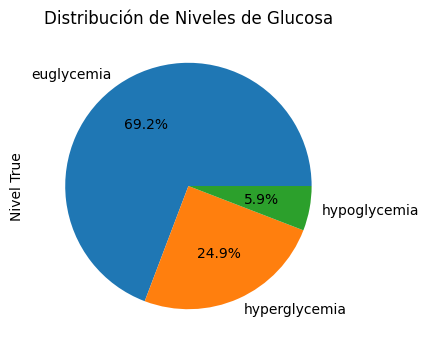

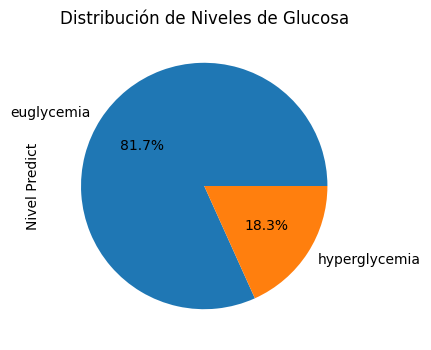

Glucose level True     Nivel True  Glucose level Predict  Nivel Predict
0               212.0  hyperglycemia             176.497787     euglycemia
1               224.0  hyperglycemia             198.008896  hyperglycemia
2               226.0  hyperglycemia             202.840149  hyperglycemia
3               227.0  hyperglycemia             213.674408  hyperglycemia
4               223.0  hyperglycemia             203.488907  hyperglycemia

In [62]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


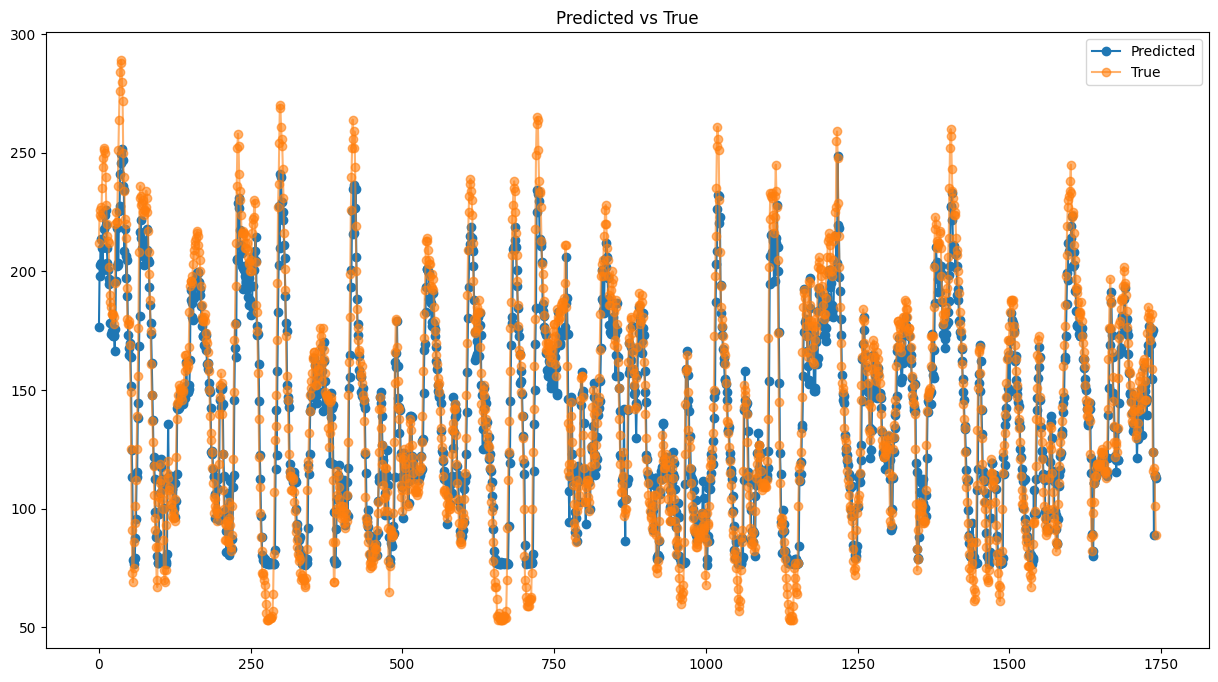

{'mae': 12.13174270734995,
 'mse': 15.542702094682697,
 'rmse': 241.57558840405392}

In [63]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [64]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=df_glucose['Glucose level True']
dfPlot['y_pred']=df_glucose['Glucose level Predict']
dfPlot.index=pd.date_range("2023-01-01", periods=len(df_glucose['Glucose level True']), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   212.0  176.497787
2023-01-01 00:15:00   224.0  198.008896
2023-01-01 00:30:00   226.0  202.840149
2023-01-01 00:45:00   227.0  213.674408
2023-01-01 01:00:00   223.0  203.488907
...                     ...         ...
2023-01-19 02:15:00   116.0  123.869232
2023-01-19 02:30:00   117.0   88.880669
2023-01-19 02:45:00   114.0  114.068451
2023-01-19 03:00:00   101.0  113.915253
2023-01-19 03:15:00    89.0  112.968887

[1742 rows x 2 columns]

AP, BE, EP: (0.9345203905801264, 0.018954623779437105, 0.04652498564043653)


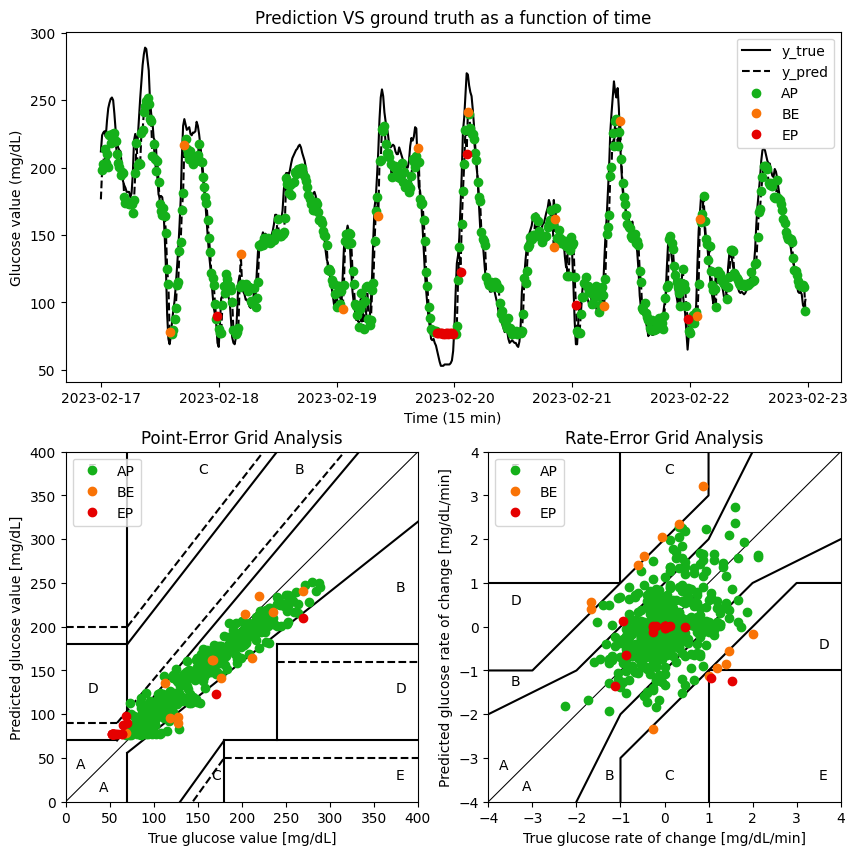

In [65]:
freq = 15
cg_ega = CG_EGA(dfPlot, freq)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

# Paciente Q3

In [66]:
paciente='paciente3'

In [67]:
with open('dataset/generado/'+paciente+'/array_Xtrain.npy', 'rb') as f:
    array_Xtrain = np.load(f)

In [68]:
len(array_Xtrain)

28683

In [69]:
with open('dataset/generado/'+paciente+'/array_Ytrain.npy', 'rb') as f:
    array_Ytrain = np.load(f)

In [70]:
len(array_Ytrain)

28683

In [71]:
with open('dataset/generado/'+paciente+'/array_Xval.npy', 'rb') as f:
    array_Xval = np.load(f)

In [72]:
len(array_Xval)

3585

In [73]:
with open('dataset/generado/'+paciente+'/array_Yval.npy', 'rb') as f:
    array_Yval = np.load(f)

In [74]:
len(array_Yval)

3585

In [75]:
with open('dataset/generado/'+paciente+'/array_Xtest.npy', 'rb') as f:
    array_Xtest = np.load(f)

In [76]:
len(array_Xtest)

3586

In [77]:
with open('dataset/generado/'+paciente+'/array_Ytest.npy', 'rb') as f:
    array_Ytest = np.load(f)

In [78]:
len(array_Ytest)

3586

In [79]:
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=3, min_delta=0.001)

# Rendimiento del Modelo base

In [80]:
base_model = keras.models.load_model(modeloBasePath)

113/113 [==============================] - 1s 5ms/step


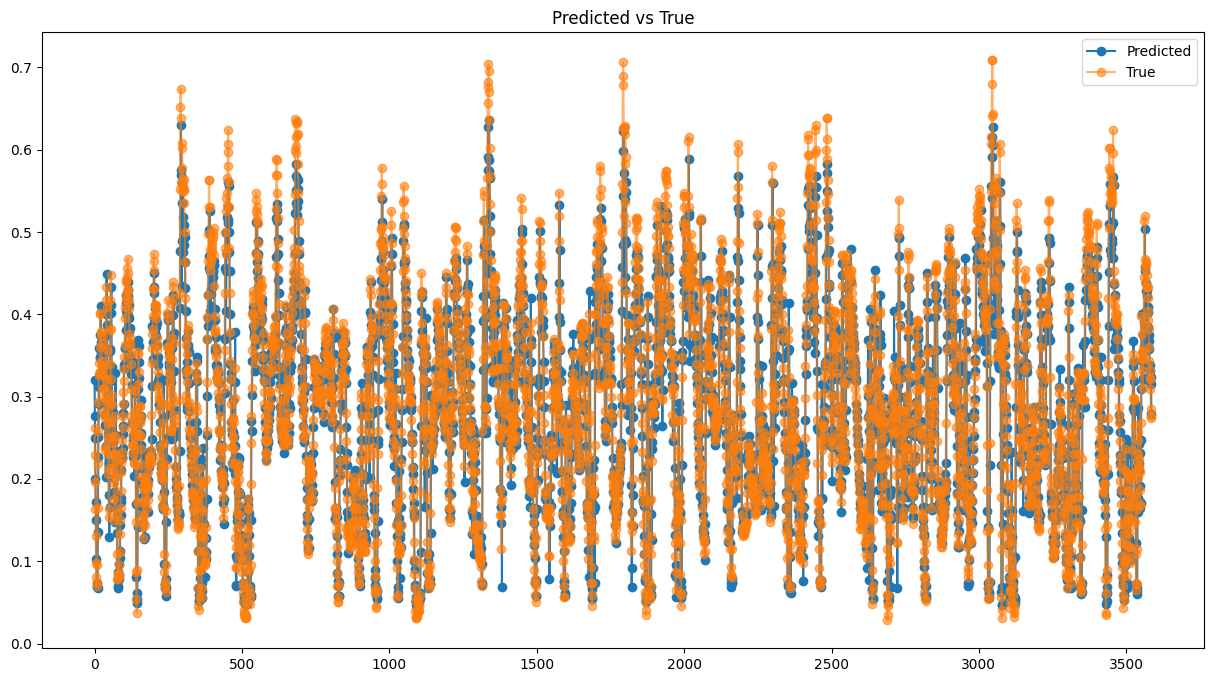

In [81]:
yhat = base_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [82]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.03608565697043894,
 'mse': 0.050227034452233046,
 'rmse': 0.002522754989865805}

# Iniciamos transfer learning

In [83]:
# Freeze the base_model
base_model.trainable = False

In [84]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [85]:
x = base_model.layers[-2].output 

x = tf.keras.layers.Dense(16, activation='relu',name='newLayer')(x) 
predictions = tf.keras.layers.Dense(1,name='output')(x) 
    
finetune_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [86]:
base_model.layers[-2].output

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dropout_2')>

In [87]:
finetune_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 5)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0   

In [88]:
finetune_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae','mse'])

history =finetune_model.fit(array_Xtrain, array_Ytrain,epochs=epochs, validation_data=(array_Xval, array_Yval), shuffle=False, callbacks=[early_stopping])
finetune_model.save('modelos/'+paciente+modeloSave)

Epoch 1/100
897/897 [==============================] - 9s 9ms/step - loss: 0.0107 - mae: 0.0665 - mse: 0.0107 - val_loss: 0.0028 - val_mae: 0.0382 - val_mse: 0.0028
Epoch 2/100
897/897 [==============================] - 7s 8ms/step - loss: 0.0036 - mae: 0.0440 - mse: 0.0036 - val_loss: 0.0032 - val_mae: 0.0413 - val_mse: 0.0032
Epoch 3/100
897/897 [==============================] - 7s 8ms/step - loss: 0.0035 - mae: 0.0433 - mse: 0.0035 - val_loss: 0.0033 - val_mae: 0.0424 - val_mse: 0.0033
Epoch 4/100
897/897 [==============================] - 7s 8ms/step - loss: 0.0035 - mae: 0.0431 - mse: 0.0035 - val_loss: 0.0034 - val_mae: 0.0434 - val_mse: 0.0034


113/113 [==============================] - 1s 5ms/step - loss: 0.0036 - mae: 0.0442 - mse: 0.0036
test loss, test acc: [0.0035967188887298107, 0.044212810695171356, 0.0035967188887298107]


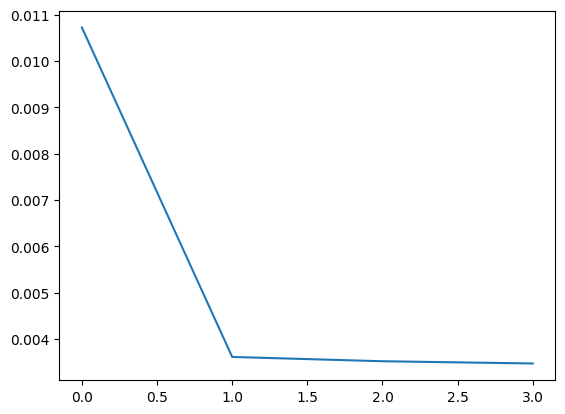

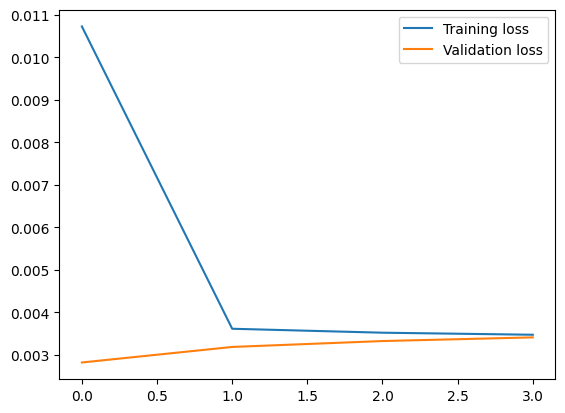

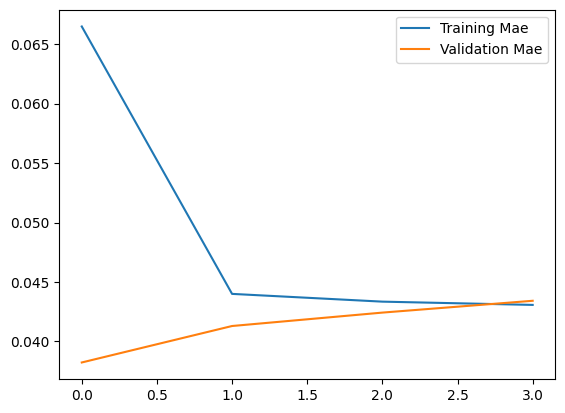

In [89]:
model_utils.modelEvaluateTraining(finetune_model,history,array_Xtest, array_Ytest)

113/113 [==============================] - 1s 4ms/step


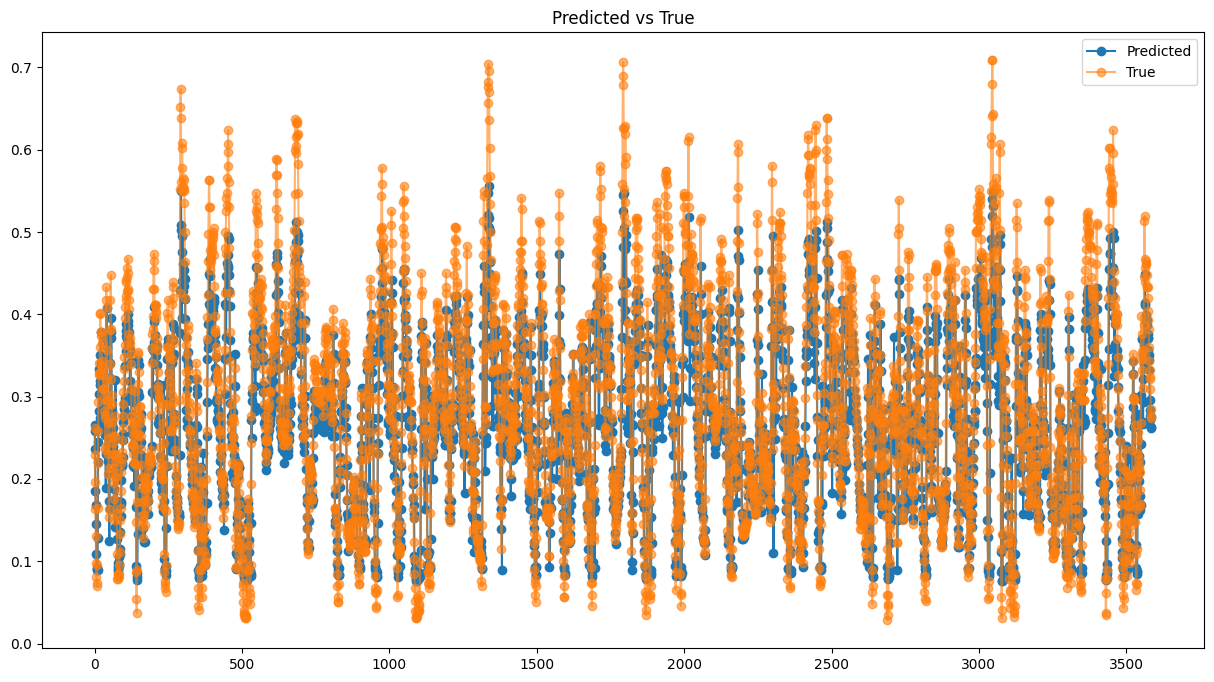

In [90]:
yhat = finetune_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [91]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.044212807114677406,
 'mse': 0.0599726480266948,
 'rmse': 0.00359671851133382}

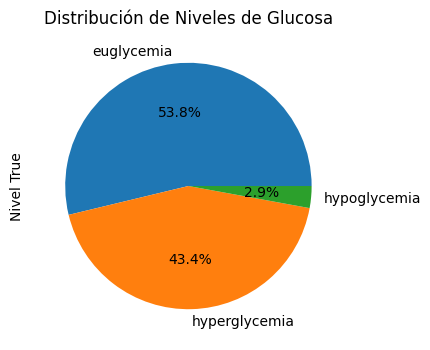

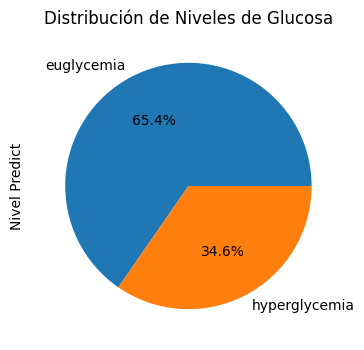

Glucose level True  Nivel True  Glucose level Predict Nivel Predict
0          160.454545  euglycemia             162.274490    euglycemia
1          145.363636  euglycemia             158.945206    euglycemia
2          130.272727  euglycemia             148.625900    euglycemia
3          115.181818  euglycemia             125.344482    euglycemia
4          100.090909  euglycemia             117.598007    euglycemia

In [92]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


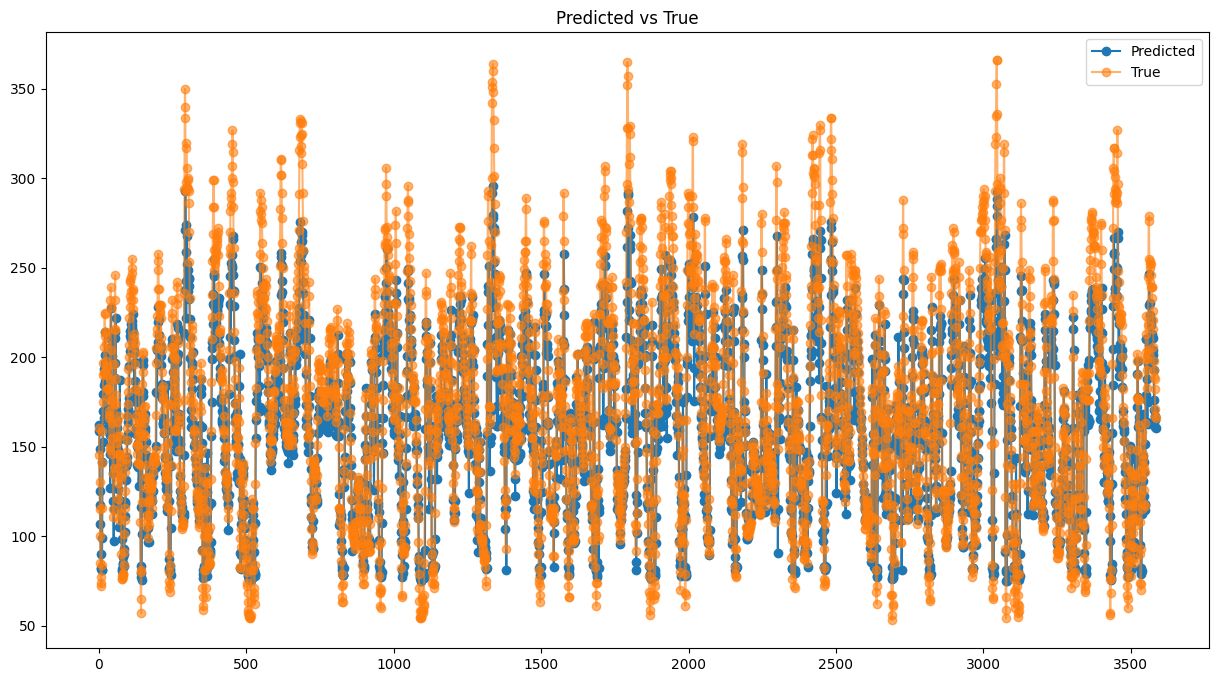

{'mae': 20.337889775978578,
 'mse': 27.587416693535367,
 'rmse': 761.0655598227539}

In [93]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [94]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=df_glucose['Glucose level True']
dfPlot['y_pred']=df_glucose['Glucose level Predict']
dfPlot.index=pd.date_range("2023-01-01", periods=len(df_glucose['Glucose level True']), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00  160.454545  162.274490
2023-01-01 00:15:00  145.363636  158.945206
2023-01-01 00:30:00  130.272727  148.625900
2023-01-01 00:45:00  115.181818  125.344482
2023-01-01 01:00:00  100.090909  117.598007
...                         ...         ...
2023-02-07 07:15:00  188.000000  166.899338
2023-02-07 07:30:00  182.000000  164.894104
2023-02-07 07:45:00  171.000000  166.582825
2023-02-07 08:00:00  167.000000  161.136703
2023-02-07 08:15:00  166.000000  160.605087

[3586 rows x 2 columns]

AP, BE, EP: (0.8772663877266388, 0.07726638772663877, 0.04546722454672245)


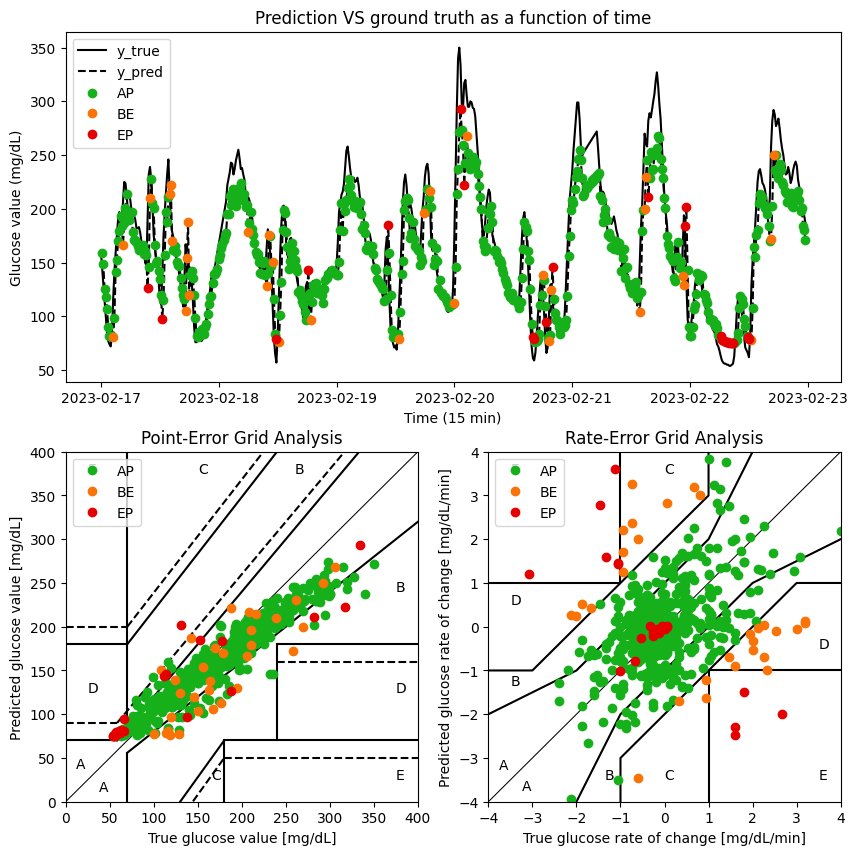

In [95]:
freq = 15
cg_ega = CG_EGA(dfPlot, freq)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

# Paciente Q4

In [96]:
paciente='paciente4'

In [97]:
with open('dataset/generado/'+paciente+'/array_Xtrain.npy', 'rb') as f:
    array_Xtrain = np.load(f)

In [98]:
len(array_Xtrain)

49606

In [99]:
with open('dataset/generado/'+paciente+'/array_Ytrain.npy', 'rb') as f:
    array_Ytrain = np.load(f)

In [100]:
len(array_Ytrain)

49606

In [101]:
with open('dataset/generado/'+paciente+'/array_Xval.npy', 'rb') as f:
    array_Xval = np.load(f)

In [102]:
len(array_Xval)

6201

In [103]:
with open('dataset/generado/'+paciente+'/array_Yval.npy', 'rb') as f:
    array_Yval = np.load(f)

In [104]:
len(array_Yval)

6201

In [105]:
with open('dataset/generado/'+paciente+'/array_Xtest.npy', 'rb') as f:
    array_Xtest = np.load(f)

In [106]:
len(array_Xtest)

6201

In [107]:
with open('dataset/generado/'+paciente+'/array_Ytest.npy', 'rb') as f:
    array_Ytest = np.load(f)

In [108]:
len(array_Ytest)

6201

In [109]:
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=3, min_delta=0.001)

# Rendimiento del Modelo base

In [110]:
base_model = keras.models.load_model(modeloBasePath)

194/194 [==============================] - 1s 4ms/step


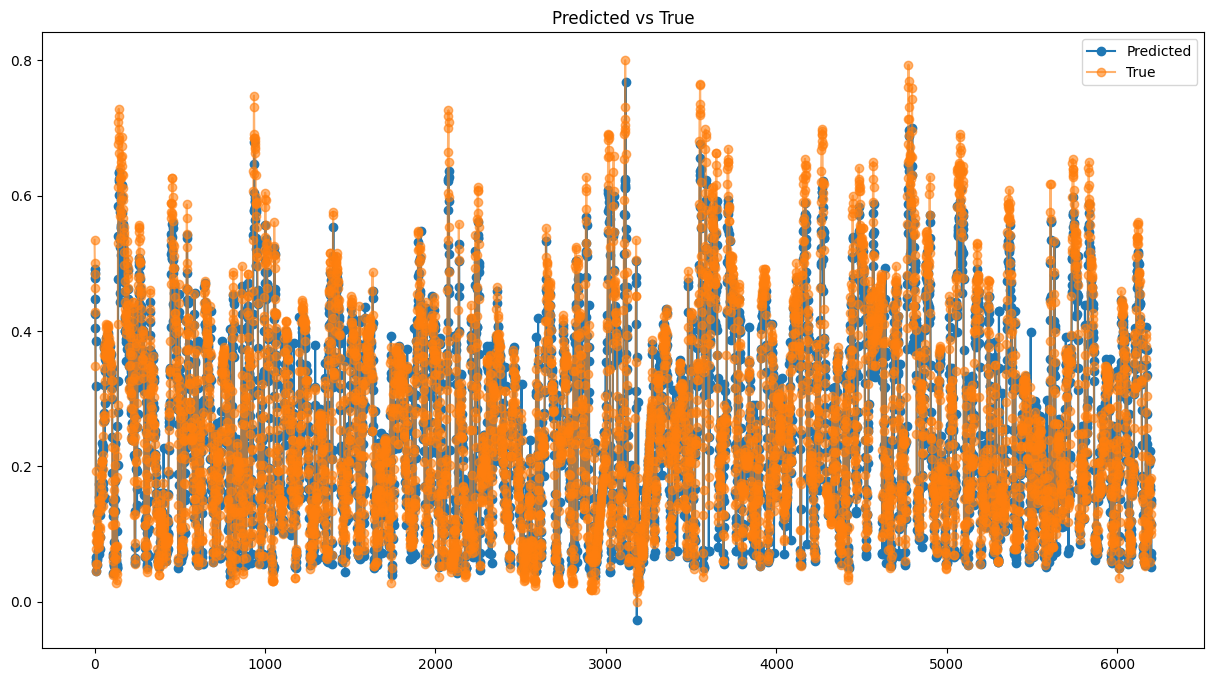

In [111]:
yhat = base_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [112]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.04068226829093997,
 'mse': 0.056452042068244924,
 'rmse': 0.0031868330536748944}

# Iniciamos transfer learning

In [113]:
# Freeze the base_model
base_model.trainable = False

In [114]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [115]:
x = base_model.layers[-2].output 

x = tf.keras.layers.Dense(16, activation='relu',name='newLayer')(x) 
predictions = tf.keras.layers.Dense(1,name='output')(x) 
    
finetune_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [116]:
base_model.layers[-2].output

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dropout_2')>

In [117]:
finetune_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 5)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0   

In [118]:
finetune_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae','mse'])

history =finetune_model.fit(array_Xtrain, array_Ytrain,epochs=epochs, validation_data=(array_Xval, array_Yval), shuffle=False, callbacks=[early_stopping])
finetune_model.save('modelos/'+paciente+modeloSave)

Epoch 1/100
1551/1551 [==============================] - 14s 8ms/step - loss: 0.0063 - mae: 0.0520 - mse: 0.0063 - val_loss: 0.0036 - val_mae: 0.0470 - val_mse: 0.0036
Epoch 2/100
1551/1551 [==============================] - 13s 8ms/step - loss: 0.0028 - mae: 0.0389 - mse: 0.0028 - val_loss: 0.0035 - val_mae: 0.0463 - val_mse: 0.0035
Epoch 3/100
1551/1551 [==============================] - 13s 8ms/step - loss: 0.0027 - mae: 0.0382 - mse: 0.0027 - val_loss: 0.0038 - val_mae: 0.0478 - val_mse: 0.0038
Epoch 4/100
1551/1551 [==============================] - 13s 8ms/step - loss: 0.0026 - mae: 0.0382 - mse: 0.0026 - val_loss: 0.0035 - val_mae: 0.0459 - val_mse: 0.0035
Epoch 5/100
1551/1551 [==============================] - 15s 9ms/step - loss: 0.0026 - mae: 0.0379 - mse: 0.0026 - val_loss: 0.0036 - val_mae: 0.0471 - val_mse: 0.0036
Epoch 6/100
1551/1551 [==============================] - 12s 8ms/step - loss: 0.0026 - mae: 0.0379 - mse: 0.0026 - val_loss: 0.0037 - val_mae: 0.0470 - val_mse:

194/194 [==============================] - 1s 5ms/step - loss: 0.0040 - mae: 0.0476 - mse: 0.0040
test loss, test acc: [0.003972354345023632, 0.04760909080505371, 0.003972354345023632]


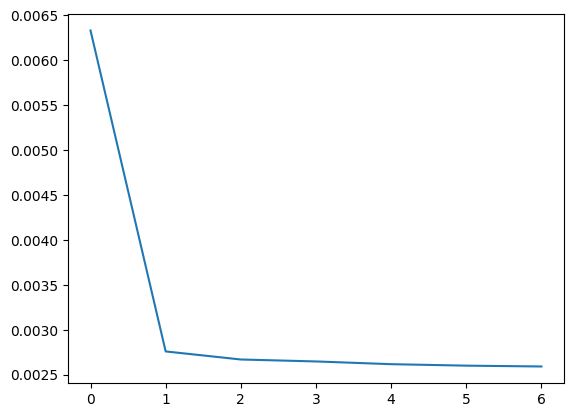

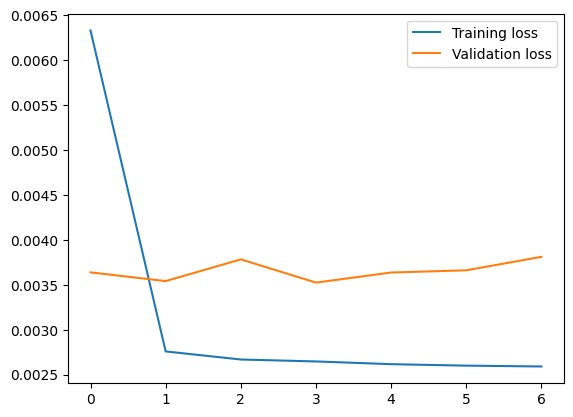

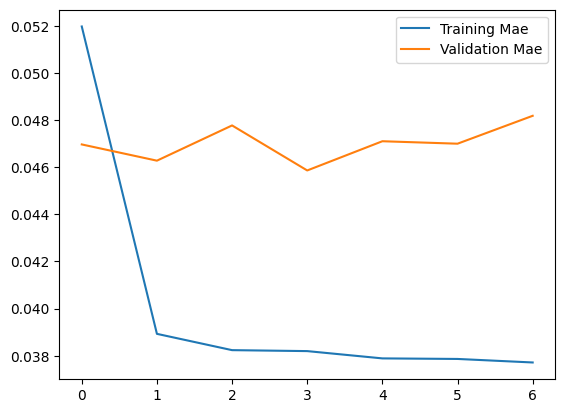

In [119]:
model_utils.modelEvaluateTraining(finetune_model,history,array_Xtest, array_Ytest)

194/194 [==============================] - 1s 4ms/step


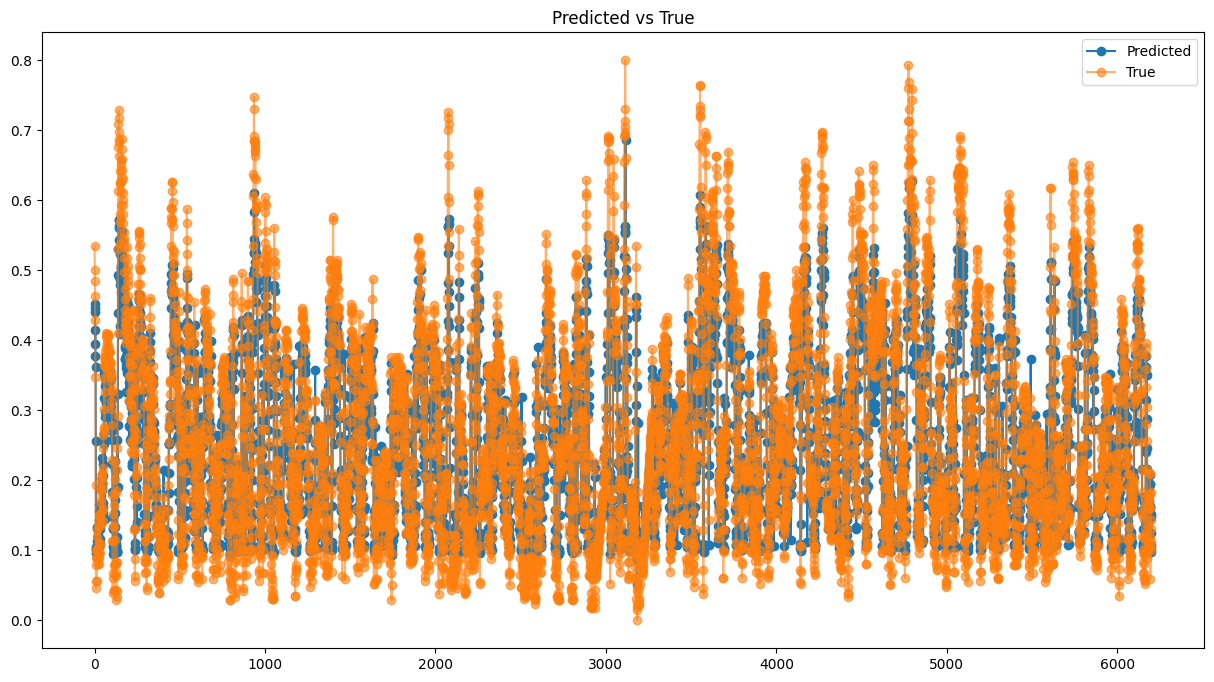

In [120]:
yhat = finetune_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [121]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.04760907992878903,
 'mse': 0.06302662816507104,
 'rmse': 0.003972355857858126}

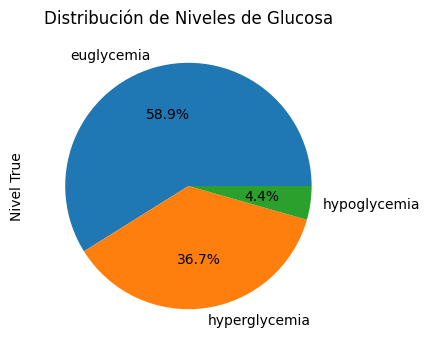

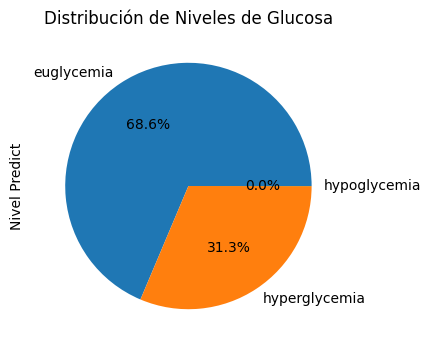

Glucose level True     Nivel True  Glucose level Predict  Nivel Predict
0               286.0  hyperglycemia             245.471649  hyperglycemia
1               270.0  hyperglycemia             247.759735  hyperglycemia
2               263.0  hyperglycemia             242.533112  hyperglycemia
3               253.0  hyperglycemia             221.695038  hyperglycemia
4               237.0  hyperglycemia             230.488998  hyperglycemia

In [122]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


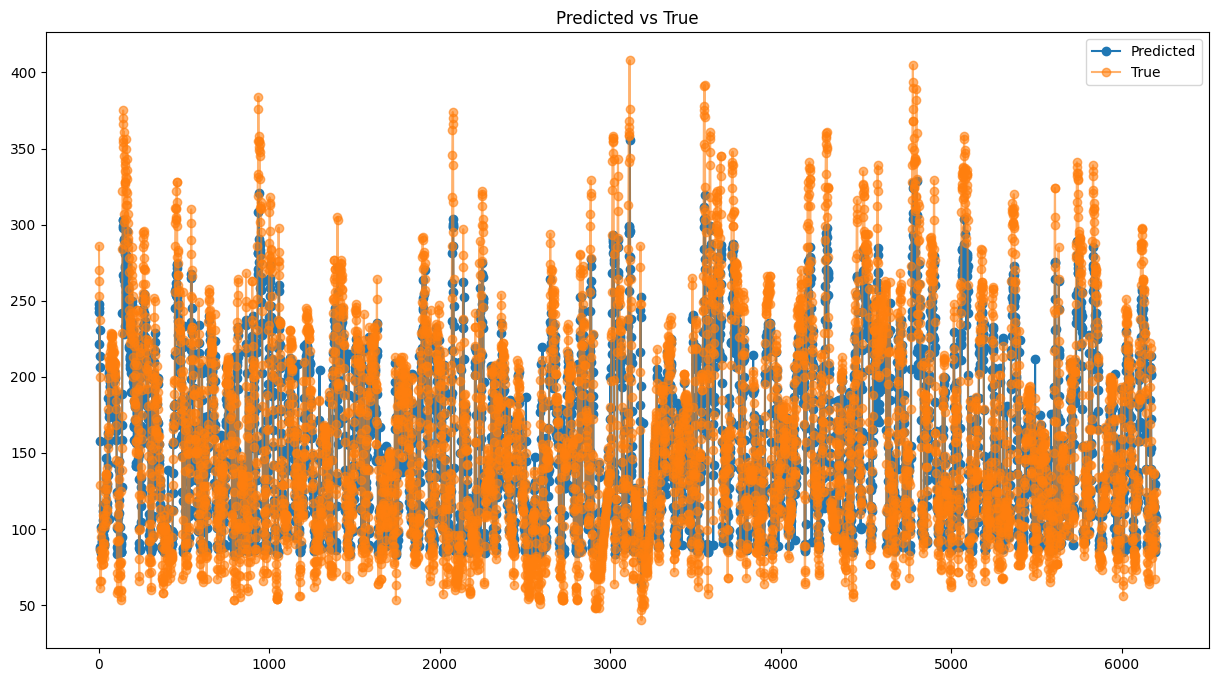

{'mae': 21.900176796905892,
 'mse': 28.99224968273382,
 'rmse': 840.5505416659794}

In [123]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [124]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=df_glucose['Glucose level True']
dfPlot['y_pred']=df_glucose['Glucose level Predict']
dfPlot.index=pd.date_range("2023-01-01", periods=len(df_glucose['Glucose level True']), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   286.0  245.471649
2023-01-01 00:15:00   270.0  247.759735
2023-01-01 00:30:00   263.0  242.533112
2023-01-01 00:45:00   253.0  221.695038
2023-01-01 01:00:00   237.0  230.488998
...                     ...         ...
2023-03-06 13:00:00   100.0   85.045662
2023-03-06 13:15:00    89.0  109.932419
2023-03-06 13:30:00    92.0   97.225441
2023-03-06 13:45:00   106.0   89.194473
2023-03-06 14:00:00   124.0  108.089394

[6201 rows x 2 columns]

AP, BE, EP: (0.8432258064516129, 0.08612903225806452, 0.07064516129032258)


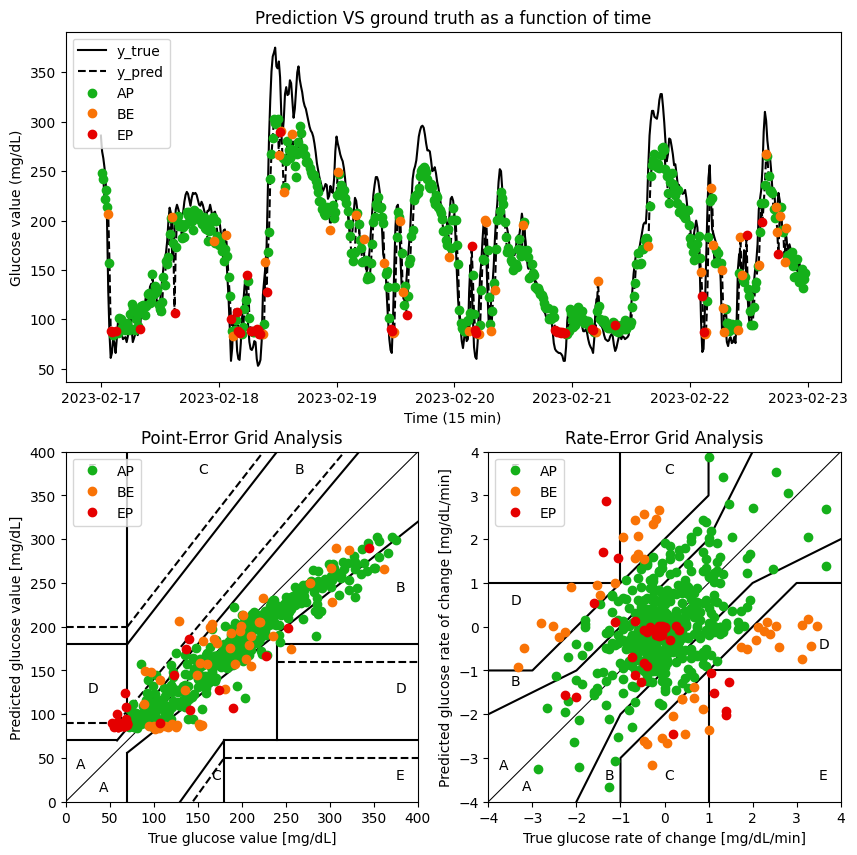

In [125]:
freq = 15
cg_ega = CG_EGA(dfPlot, freq)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)